<a href="https://colab.research.google.com/github/adamgogacz/time-series-processing/blob/main/pulse_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2022 d-Analytics. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**To execute the code scroll down and run the "main" function; comment/uncomment lines to test the various filters (fft and convolution implementations).**

In [ ]:
from scipy.signal import correlate as scipy_corr

In [ ]:
import numpy as np
from matplotlib import pyplot as plt 
from scipy.stats import norm
from scipy.fft import fft, ifft
import bottleneck as bn
%matplotlib inline
plt.rcParams.update({'font.size': 8})

In [ ]:
def cdf_diff(winlen:int, loc1:float, scale1:float, loc2:float, scale2:float):
  'Difference of 2 Gaussian CDFs'
  Nrfft=winlen//2+1
  x=np.linspace(0,0.5,Nrfft)
  win=norm.cdf(x,loc=loc1,scale=scale1) - norm.cdf(x,loc=loc2,scale=scale2)
  win[win<0]=0.
  if np.mod(winlen,2) == 1:
    win=np.concatenate((win,np.flip(win[1:])))
  else:
    win=np.concatenate((win,np.flip(win[1:-1])))
  return win

In [ ]:
def trapezoid(winlen:int, a0:float, loc0:float, loc1:float, loc2:float, loc3:float, a1:float, smoothlen:int=3):
  'Trapezoidal window: bandpass'
  assert winlen > 3, 'Filter length too short'
  assert a0 >= 0 and a0 <=1 and a1 >= 0 and a1 <=1, 'a0 and a1 must satisfy: 0 <= a0, a1, <= 1'
  assert loc0 > 0 and loc3 < 0.5 and loc1 > loc0 and loc2 > loc1 and loc3 > loc2,\
  'Corner frequencies must satisfy 0 < loc0 < loc1 < loc2 < loc3 < 0.5'
  Nrfft=winlen//2+1
  win=np.zeros(Nrfft)
  i0=int(2*loc0*(Nrfft-1))
  i1=int(2*loc1*(Nrfft-1))
  i2=int(2*loc2*(Nrfft-1))
  i3=int(2*loc3*(Nrfft-1))
  win[0:i0]=np.linspace(0,a0,i0)
  win[i0:i1]=np.linspace(a0,1.,i1-i0)
  win[i1:i2]=np.linspace(1.,1.,i2-i1)
  win[i2:i3]=np.linspace(1.,a1,i3-i2)
  win[i3:]=np.linspace(a1,0.,Nrfft-i3)
  win=np.convolve(win,np.ones(smoothlen)/smoothlen,'same')
  if np.mod(winlen,2) == 1:
    win=np.concatenate((win,np.flip(win[1:])))
  else:
    win=np.concatenate((win,np.flip(win[1:-1])))
  return win

In [ ]:
def gauss(winlen:int, loc:float, scale:float):
  'Gaussian window: bandpass'
  assert winlen > 3, 'Filter length too short'
  Nrfft=winlen//2+1
  x=np.linspace(0,0.5,Nrfft)
  win=norm.pdf(x,loc=loc,scale=scale)
  if np.mod(winlen,2) == 1:
    win=np.concatenate((win,np.flip(win[1:])))
  else:
    win=np.concatenate((win,np.flip(win[1:-1])))
  return win

In [ ]:
def butterworth_lc(winlen:int, fc:float, order:int=5):
  'Butterworth window: low-cut'
  assert winlen > 3, 'Filter length too short'
  assert fc > 0 and fc < 0.5, 'Corner frequency must satisfy: 0 < fc < 0.5'
  assert order > 0, '"order" must be a positive integer'
  Nrfft=winlen//2+1
  x=np.linspace(0.5,0.,Nrfft)
  win=1/(1+(x/(0.5-fc))**(2*order))
  if np.mod(winlen,2) == 1:
    win=np.concatenate((win,np.flip(win[1:])))
  else:
    win=np.concatenate((win,np.flip(win[1:-1])))
  return win

In [ ]:
def butterworth_hc(winlen:int, fc:float, order:int=5):
  'Butterworth window: high-cut'
  assert winlen > 3, 'Filter length too short'
  assert fc > 0 and fc < 0.5, 'Corner frequency must satisfy: 0 < fc < 0.5'
  assert order > 0, '"order" must be a positive integer'
  Nrfft=winlen//2+1
  x=np.linspace(0.,0.5,Nrfft)
  win=1/(1+(x/fc)**(2*order))
  if np.mod(winlen,2) == 1:
    win=np.concatenate((win,np.flip(win[1:])))
  else:
    win=np.concatenate((win,np.flip(win[1:-1])))
  return win

In [ ]:
def sin_nthroot(winlen:int, nroot:int=5):
  'Nth-root of sine function: low-cut'
  assert winlen > 3, 'Filter length too short'
  assert nroot >= 0, 'nth-root must be non-negative'
  Nrfft=winlen//2+1
  win=np.sin(np.linspace(0,np.pi/2.,Nrfft))**(1/nroot)
  if np.mod(winlen,2) == 1:
    win=np.concatenate((win,np.flip(win[1:])))
  else:
    win=np.concatenate((win,np.flip(win[1:-1])))
  return win

In [ ]:
def cos_nthroot(winlen:int, nroot:int=5):
  'Nth-root of cosine function: high-cut'
  assert winlen > 3, 'Filter length too short'
  assert nroot >= 0, 'nth-root must be non-negative'
  Nrfft=winlen//2+1
  win=np.cos(np.linspace(0,np.pi/2.,Nrfft))**(1/nroot)
  if np.mod(winlen,2) == 1:
    win=np.concatenate((win,np.flip(win[1:])))
  else:
    win=np.concatenate((win,np.flip(win[1:-1])))
  return win

In [ ]:
def sinc(siglen:int=1001):
  'Sinc filter'
  assert siglen > 3, 'Filter length too short!'
  siglen=2*(siglen//2)+1
  xarr=np.linspace(-(siglen//2.25),siglen//2.25,siglen)
  fsinc=np.sinc(xarr)
  return fsinc

In [ ]:
def genSweep(f0:float, f1:float, siglen:int):
  'Linear sweep generator with front/back zero padding'
  assert siglen > 3, 'Not enough samples to get things going'
  assert f0 > 0 and f1 > f0 and f1 < 1, 'The following condition was not met: 0 < f0 < f1 < 1'
  x=np.linspace(0,1,siglen)
  return np.concatenate((np.zeros(siglen//10),np.sin(np.pi/8+2.*np.pi*siglen*(f0*x+((f1-f0)/2.)*x**2)),np.zeros(siglen//20)))

In [ ]:
def genSpike(k:int, siglen:int):
  'Spike signal generator'
  assert siglen > 3, 'Not enough samples to get things going'
  assert k >= 0 and k < siglen, 'The following condition was not met: 0 <= k < siglen'
  x=np.zeros(siglen)
  x[k]=1
  return x

In [ ]:
def applyFffFilt(sig:np.ndarray,fftwin:np.ndarray):
  'Filtering in the frequency domain'
  assert len(sig) == len(fftwin), 'Signal and window arrays must be equal size'
  return np.real(ifft(fftwin*fft(sig)))/np.sqrt(2*np.pi)

In [ ]:
def applyConvFilt(sig:np.ndarray,fftwin:np.ndarray,threshold:float=0.95,minlen:int=15):
  'Filtering in the sample domain via convolution'
  FSINC=fftwin*fft(sinc(len(sig)))
  filt=np.real(ifft(FSINC))
  #--- get (two-sided) cumulative (L_1) energy away from the peak of sinc
  Esym=2.*np.cumsum(np.abs(filt[len(filt)//2:]))-filt[len(filt)//2] # exploiting symmetry and avoiding counting the peak twice
  Esym=Esym/Esym[-1] # normalizing by the total L1 energy
  idx=np.maximum(np.argmax(Esym >= threshold), np.minimum(minlen//2+1,len(Esym)))
  idxUsemin=len(filt)//2-idx+1
  idxUsemax=len(filt)//2+idx
  #--- form the filter
  filt=filt[idxUsemin:idxUsemax]
  filt=filt/np.sum(np.abs(filt))
  sigfilt=np.convolve(sig,filt,mode='same')
  return sigfilt, filt

In [ ]:
def plotResults(sig:np.ndarray, sigfiltconv:np.ndarray, sigfiltfft:np.ndarray, fftwin:np.ndarray, filtconv:np.ndarray):   
  fig, axs=plt.subplots(3, 3)
  fig.set_size_inches(30, 15)
  Nfreqxlabel=8; freqxlabelint=np.linspace(0,(Nfreqxlabel-1)/Nfreqxlabel,Nfreqxlabel)
  #freqxlabels=['$0$', r'$\frac{1}{8}$', r'$\frac{1}{4}$', r'$\frac{3}{8}$', r'$-\frac{1}{2}$', r'$-\frac{3}{8}$', r'$-\frac{1}{4}$', r'$-\frac{1}{8}$']
  freqxlabels=[str(np.round(x,2)) for x in np.fft.fftfreq(Nfreqxlabel,1)]
  #--- signal function 
  idxSigmin=0; idxSigmax=len(sig)-1
  xsig=np.arange(len(sig))
  axs[0,0].plot(xsig[idxSigmin:idxSigmax],sig[idxSigmin:idxSigmax])
  axs[0,0].set_xlabel('Sample')
  axs[0,0].set_xlim(xsig[idxSigmin],xsig[idxSigmax])
  axs[0,0].set_title(label=f'Input signal (length = {len(sig)} samples)',fontdict=None, loc='center', pad=None)
  #--- FFT amplitude of the input signal
  SIG=np.abs(fft(sig))
  freqs=np.arange(len(SIG))
  axs[0,1].fill_between(freqs,SIG,0.,color='maroon')
  axs[0,1].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
  axs[0,1].set_xlim(freqs.min(),freqs.max())
  axs[0,1].set_xticks(len(SIG)*freqxlabelint)
  axs[0,1].set_xticklabels(freqxlabels)
  axs[0,1].set_title(label='FFT amplitude of input signal',fontdict=None, loc='center', pad=None)
  #--- FFT amplitude of the window function
  freqs=np.arange(len(fftwin))
  axs[0,2].fill_between(freqs,fftwin,0.,color='maroon')
  axs[0,2].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
  axs[0,2].set_ylim(fftwin.min(),fftwin.max())
  axs[0,2].set_xlim(freqs.min(),freqs.max())
  axs[0,2].set_xticks(len(fftwin)*freqxlabelint)
  axs[0,2].set_xticklabels(freqxlabels)
  axs[0,2].set_title(label='FFT window function',fontdict=None, loc='center', pad=None)
  #--- convolution-filtered signal
  idxmin=0; idxmax=len(sigfiltconv)-1
  # idxmin=50; idxmax=200
  xfilt=np.arange(len(sigfiltconv))
  axs[1,0].plot(xfilt[idxmin:idxmax],sigfiltconv[idxmin:idxmax])
  axs[1,0].set_xlabel('Sample')
  axs[1,0].set_xlim(xfilt[idxmin],xfilt[idxmax])
  axs[1,0].set_title(label=f'Convolution-filtered (filter length = {len(filtconv)} samples)',fontdict=None, loc='center', pad=None)
  #--- FFT amplitude of the convolution-filtered signal
  SIG_FILT=np.abs(fft(sigfiltconv))
  freqs=np.arange(len(SIG_FILT))
  axs[1,1].fill_between(freqs,SIG_FILT,0.,color='maroon')
  axs[1,1].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
  axs[1,1].set_xlim(freqs.min(),freqs.max())
  axs[1,1].set_xticks(len(SIG_FILT)*freqxlabelint)
  axs[1,1].set_xticklabels(freqxlabels)
  axs[1,1].set_title(label='FFT amplitude of convolution-filtered signal',fontdict=None, loc='center', pad=None)
  #--- FFT phase of the convolution-filtered signal
  SIG_FILT=np.unwrap(np.angle((fft(sigfiltconv))))
  freqs=np.arange(len(SIG_FILT))
  axs[1,2].plot(freqs,SIG_FILT,color='maroon')
  axs[1,2].set(xlabel='Freq (normalized)', ylabel='Phase (rad)')
  axs[1,2].set_xlim(freqs.min(),freqs.max())
  axs[1,2].set_xticks(len(SIG_FILT)*freqxlabelint)
  axs[1,2].set_xticklabels(freqxlabels)
  axs[1,2].set_title(label='FFT phase of convolution-filtered signal',fontdict=None, loc='center', pad=None)
  #--- fft-filtered signal
  idxmin=0; idxmax=len(sigfiltfft)-1
  # idxmin=50; idxmax=200
  xfilt=np.arange(len(sigfiltfft))
  axs[2,0].plot(xfilt[idxmin:idxmax],sigfiltfft[idxmin:idxmax])
  axs[2,0].set_xlabel('Sample')
  axs[2,0].set_xlim(xfilt[idxmin],xfilt[idxmax])
  axs[2,0].set_title(label='FFT-filtered',fontdict=None, loc='center', pad=None)
  #--- FFT amplitude of the fft-filtered signal
  SIG_FILT=np.abs(fft(sigfiltfft))
  freqs=np.arange(len(SIG_FILT))
  axs[2,1].fill_between(freqs,SIG_FILT,0.,color='maroon')
  axs[2,1].set(xlabel='Freq (normalized)', ylabel='FFT Amplitude')
  axs[2,1].set_xlim(freqs.min(),freqs.max())
  axs[2,1].set_xticks(len(SIG_FILT)*freqxlabelint)
  axs[2,1].set_xticklabels(freqxlabels)
  axs[2,1].set_title(label='FFT amplitude of fft-filtered signal',fontdict=None, loc='center', pad=None)
  #--- FFT phase of the fft-filtered signal
  SIG_FILT=np.unwrap(np.angle((fft(sigfiltfft))))
  freqs=np.arange(len(SIG_FILT))
  axs[2,2].plot(freqs,SIG_FILT,color='maroon')
  axs[2,2].set(xlabel='Freq (normalized)', ylabel='Phase (rad)')
  axs[2,2].set_xlim(freqs.min(),freqs.max())
  axs[2,2].set_xticks(len(SIG_FILT)*freqxlabelint)
  axs[2,2].set_xticklabels(freqxlabels)
  axs[2,2].set_title(label='FFT phase of fft-filtered signal',fontdict=None, loc='center', pad=None)
  #--- final adjsutments
  #fig.tight_layout()
  plt.show()

# MAIN FUNCTION:

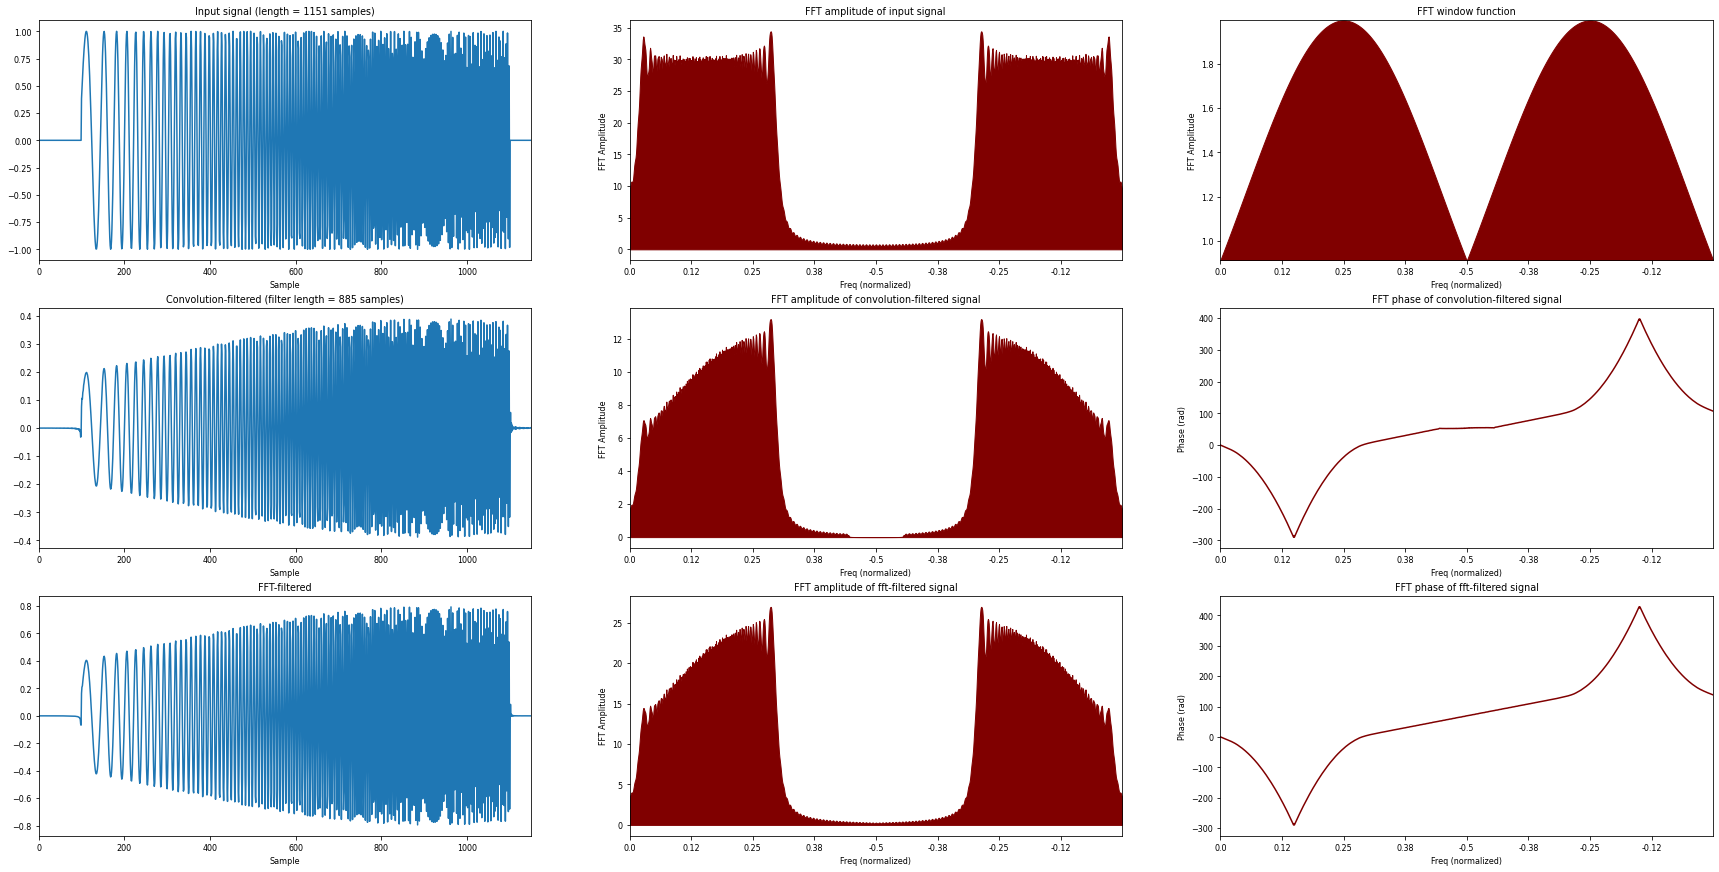

In [ ]:
def main():
  'Filter testing utility; all frequencies are normalized between 0 and 0.5 = Nyquist.'
  #==============================
  # STEP 1: generate signal
  #==============================
  signal=genSweep(f0=0.015,f1=0.3,siglen=1001) # sweep
  # signal=genSpike(k=100,siglen=1001) # spike
  # signal=sinc(siglen=1021) # sinc
  #==============================
  # STEP 2: select fft window
  #==============================
  # fftwin = cdf_diff(winlen=len(signal), loc1=0.05, scale1=0.1, loc2=0.5, scale2=1)
  fftwin = gauss(winlen=len(signal), loc=0.25, scale=0.2)
  # fftwin = sin_nthroot(winlen=len(signal),nroot=5)
  # fftwin = cos_nthroot(winlen=len(signal),nroot=1/3)
  # fftwin = sin_nthroot(winlen=len(signal),nroot=5)*cos_nthroot(winlen=len(signal),nroot=1/2)
  # fftwin = trapezoid(winlen=len(signal), a0=0.005, loc0=0.015, loc1=0.1, loc2=0.25, loc3=0.35, a1=0.05, smoothlen=15)
  # fftwin = butterworth_hc(winlen=len(signal), fc=0.25, order=6)
  # fftwin = butterworth_lc(winlen=len(signal), fc=0.01, order=51)*butterworth_hc(winlen=len(signal), fc=0.25, order=6)
  #==============================
  # STEP 3: apply fft and convolution filters
  #==============================
  sigfiltfft = applyFffFilt(sig=signal, fftwin=fftwin)
  sigfiltconv, filtconv = applyConvFilt(sig=signal, fftwin=fftwin, threshold=0.975, minlen=5)
  #==============================
  # STEP 4: plot results
  #==============================
  # sigfiltconv=filtconv # uncomment this line to examine the filter; the results are placed in the covolution-based filter axes
  plotResults(sig=signal, sigfiltconv=sigfiltconv, sigfiltfft=sigfiltfft, fftwin=fftwin, filtconv=filtconv)
    
if __name__=="__main__":
    main()